In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms

In [24]:
# device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Current device is', device)

# for reproducibility
torch.manual_seed(2023)
if device == 'cuda':
    torch.cuda.manual_seed_all(2023)

Current device is cuda


In [25]:
import shutil
import os

# 손상된 캐시 폴더 삭제
cache_dir = os.path.expanduser("~/.cache/kagglehub")
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)
    print("KaggleHub cache deleted.")

KaggleHub cache deleted.


In [26]:
import kagglehub

path = kagglehub.dataset_download("andrewmvd/metastatic-tissue-classification-patchcamelyon")
print("Path to dataset files:", path)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7.47G/7.47G [11:35<00:00, 11.5MB/s]

Extracting files...


Path to dataset files: C:\Users\roobe\.cache\kagglehub\datasets\andrewmvd\metastatic-tissue-classification-patchcamelyon\versions\9


In [27]:
import os

# 사용자 홈 기준으로 자동 경로 설정
base_path = os.path.expanduser("~/.cache/kagglehub/datasets/andrewmvd/metastatic-tissue-classification-patchcamelyon")

# 모든 하위 버전 디렉토리 확인
for root, dirs, files in os.walk(base_path):
    print("📁", root)
    for f in files:
        print("   └─", f)


📁 C:\Users\roobe/.cache/kagglehub/datasets/andrewmvd/metastatic-tissue-classification-patchcamelyon
   └─ 9.complete
📁 C:\Users\roobe/.cache/kagglehub/datasets/andrewmvd/metastatic-tissue-classification-patchcamelyon\versions
📁 C:\Users\roobe/.cache/kagglehub/datasets/andrewmvd/metastatic-tissue-classification-patchcamelyon\versions\9
📁 C:\Users\roobe/.cache/kagglehub/datasets/andrewmvd/metastatic-tissue-classification-patchcamelyon\versions\9\camelyonpatch_level_2_split_train_mask
   └─ camelyonpatch_level_2_split_train_mask.h5
📁 C:\Users\roobe/.cache/kagglehub/datasets/andrewmvd/metastatic-tissue-classification-patchcamelyon\versions\9\Labels
📁 C:\Users\roobe/.cache/kagglehub/datasets/andrewmvd/metastatic-tissue-classification-patchcamelyon\versions\9\Labels\Labels
   └─ camelyonpatch_level_2_split_test_y.h5
   └─ camelyonpatch_level_2_split_train_y.h5
   └─ camelyonpatch_level_2_split_valid_y.h5
📁 C:\Users\roobe/.cache/kagglehub/datasets/andrewmvd/metastatic-tissue-classification-pa

In [28]:
import os
import h5py

# Windows 사용자 홈 디렉토리 기준 경로
data_dir = os.path.expanduser("~/.cache/kagglehub/datasets/andrewmvd/metastatic-tissue-classification-patchcamelyon/versions/9/pcam")
h5_file = os.path.join(data_dir, "training_split.h5")

# HDF5 파일 내부 키 확인
with h5py.File(h5_file, "r") as file:
    print("✅ HDF5 파일 로드 성공!")
    print("📂 포함된 키 목록:", list(file.keys()))

✅ HDF5 파일 로드 성공!
📂 포함된 키 목록: ['x']


In [29]:
import h5py
import torch
from torch.utils.data import Dataset,DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args

import matplotlib.pyplot as plt

In [30]:
import h5py
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(), #과적합 방지 위해서 뒤집은 데이터도 학습-> 데이터 늘림
    transforms.RandomRotation(10),#과적합 방지 위해서 데이터 10도 회전시켜서 학습
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


class HDF5Dataset(Dataset):
    def __init__(self, image_h5_path, label_h5_path, transform=None):
        self.image_h5_path = image_h5_path
        self.label_h5_path = label_h5_path
        self.transform = transform

        # 전체 개수만 한 번 불러와서 저장 (파일은 닫음)
        with h5py.File(self.image_h5_path, "r") as img_file:
            self.length = img_file["x"].shape[0]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # 매 호출마다 파일 다시 열기 (느리지만 메모리 절약)
        with h5py.File(self.image_h5_path, "r") as img_file, h5py.File(self.label_h5_path, "r") as lbl_file:
            image = img_file["x"][idx]
            label = lbl_file["y"][idx]

        image = Image.fromarray(image.astype(np.uint8))  # (H, W, C)

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label).squeeze().long()
        return image, label

    
# 데이터셋 경로 설정
# 경로 수정
data_dir = os.path.expanduser("~/.cache/kagglehub/datasets/andrewmvd/metastatic-tissue-classification-patchcamelyon/versions/9")
image_dir = os.path.join(data_dir, "pcam")  # ✅ 여기까지만
label_dir = os.path.join(data_dir, "Labels", "Labels")  # ✅ 그대로 유지


# 학습 데이터 로드
train_dataset = HDF5Dataset(
    image_h5_path=os.path.join(image_dir, "training_split.h5"),
    label_h5_path=os.path.join(label_dir, "camelyonpatch_level_2_split_train_y.h5"),  # 수정된 레이블 경로
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 검증 데이터 로드
val_dataset = HDF5Dataset(
    image_h5_path=os.path.join(image_dir, "validation_split.h5"),
    label_h5_path=os.path.join(label_dir, "camelyonpatch_level_2_split_valid_y.h5"),  # 수정된 레이블 경로
    transform=transform
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 테스트 데이터 로드
test_dataset = HDF5Dataset(
    image_h5_path=os.path.join(image_dir, "test_split.h5"),
    label_h5_path=os.path.join(label_dir, "camelyonpatch_level_2_split_test_y.h5"),  # 수정된 레이블 경로
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 데이터 개수 확인
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")



Train dataset size: 262144
Validation dataset size: 32768
Test dataset size: 32768


In [31]:
import torchvision.models as models

# 사전 학습된 ResNet-18 모델 불러오기
model = models.resnet18(weights=None)

model.eval()  # 추론 모드로 설정
model.fc = nn.Linear(model.fc.in_features, 2) # PCam은 양성/음성 2클래스
model = model.to(device)
learning_rate = 0.009
epochs = 4
# define loss & optimizer
criterion = nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
# hyperparameters
learning_rate = 0.009
epochs = 5



# define loss & optimizer
criterion = nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [33]:
train_batch = len(train_loader)
val_batch = len(val_loader)

In [34]:
print('Learning started.')

train_loss_list = []
train_acc_list = []

val_loss_list = []
val_acc_list = []

best_val_loss = 10**9           # 초기값을 매우 큰 값으로 설정
patience_limit = 3              # 최대 몇 번의 epoch까지 개선 없음을 허용할지
patience_check = 0              # 현재 몇 epoch 연속으로 개선되지 않았는지

for epoch in range(epochs):
    # ----------------- Training -----------------
    model.train()
    train_loss = 0
    correct = 0

    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device).squeeze()

        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() / train_batch

        correct_prediction = torch.argmax(Y_pred, 1) == Y
        correct += correct_prediction.sum().item()

    train_acc = 100 * correct / len(train_loader.dataset)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # ----------------- Validation -----------------
    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0

        for X, Y in val_loader:
            X = X.to(device)
            Y = Y.to(device).squeeze()

            Y_pred = model(X)
            loss = criterion(Y_pred, Y)

            val_loss += loss.item() / val_batch

            correct_prediction = torch.argmax(Y_pred, 1) == Y
            correct += correct_prediction.sum().item()

        val_acc = 100 * correct / len(val_loader.dataset)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

    # ----------------- Logging -----------------
    print("[Epoch %2d] loss %.4f  acc %.2f%%, val loss %.4f  val acc %.2f%%"
          % (epoch + 1, train_loss, train_acc, val_loss, val_acc))

    # ----------------- Early Stopping -----------------
    if val_loss > best_val_loss:
        patience_check += 1
        if patience_check >= patience_limit:
            print('Early Stopping!')
            break
    else:
        best_val_loss = val_loss
        patience_check = 0

print('Learning Finished!')                                                                 


Learning started.
[Epoch  1] loss 0.4453  acc 79.55%, val loss 0.4010  val acc 81.43%
[Epoch  2] loss 0.3733  acc 83.75%, val loss 0.3925  val acc 81.59%
[Epoch  3] loss 0.3308  acc 85.98%, val loss 0.3853  val acc 83.21%
[Epoch  4] loss 0.3033  acc 87.31%, val loss 0.4850  val acc 79.71%
[Epoch  5] loss 0.2813  acc 88.44%, val loss 0.3619  val acc 84.38%
Learning Finished!


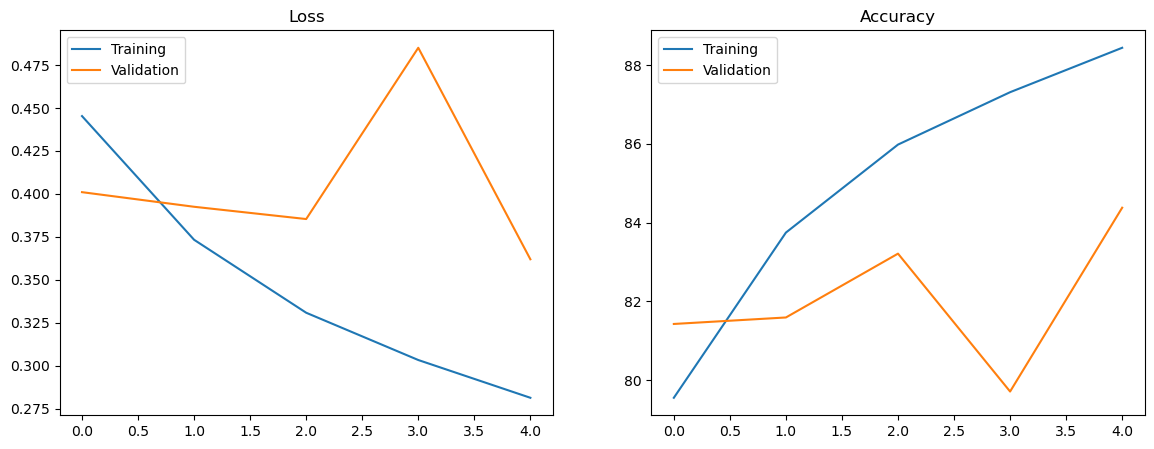

In [35]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.plot(range(len(train_loss_list)), train_loss_list, range(len(val_loss_list)), val_loss_list)
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(range(len(train_acc_list)), train_acc_list, range(len(val_acc_list)),val_acc_list)
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.show()

In [36]:
with torch.no_grad():
    correct = 0
    # Test the model using test sets
    for X, Y in test_loader:
        X_test = X.to(device)
        Y_test = Y.to(device)

        Y_pred = model.forward(X_test)
        prediction = torch.argmax(Y_pred, 1)
        correct_prediction = prediction == Y_test
        correct += correct_prediction.sum()

    accuracy = 100*correct/len(test_loader.dataset)  
    print('Test set Accuracy: %.2f' % (accuracy))

Test set Accuracy: 82.91


In [ ]:
import numpy as np
labels = np.concatenate([train_dataset.labels, val_dataset.labels])
print(np.unique(labels, return_counts=True))


In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")
